# LSTM

In [1]:
import numpy as np
import pandas as pd 
import re
import helper
import random
import string
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pdb

import time
import math

In [2]:
# Run this to reload helper.py so you don't have to restart the kernel
import importlib

importlib.reload(helper)

<module 'helper' from '/Users/glchau/Desktop/Caltech/CS155/loan-sharks/poems/helper.py'>

## Preprocess data

In [3]:
all_words, all_sequences, word_dict, all_sonnet_int = helper.getAllWordsAndSequences("data/shakespeare.txt", "data/Syllable_dictionary.txt")

## Variables and helper functions for RNN training 

In [4]:
all_character_sequences = [' '.join(seq[:-1]) for seq in all_sequences]
all_character_sequences_no_empty = [seq for seq in all_character_sequences if len(seq) > 0]


In [5]:
fixed_length_character_sequences_valid_start = [] 
big_string = ' '.join(all_character_sequences_no_empty)
big_string = ' ' + big_string
step_size = 5
for i in range(0, len(big_string)):
    if (big_string[i-1] == ' ') and (big_string[i] != ' '):
        if len(big_string[i:i+40]) == 40: 
            fixed_length_character_sequences_valid_start.append(big_string[i:i+40])        

In [6]:
len(fixed_length_character_sequences_valid_start)

17566

In [12]:
all_letters = string.ascii_lowercase + " '-"  # abcdefghijklmnopqrstuvwxyz '-
n_letters = len(all_letters) + 1 # Plus EOS marker
all_categories = [0] # Only have 1 category for now. We could try to categorize lines by position or ending rhyme
n_categories = len(all_categories)

lens = [len(seq) for seq in fixed_length_character_sequences_valid_start]
max_length = max(lens)
min_lenth = min(lens)
max_length

40

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [13]:
def inputTensor(line):
    # One-hot matrix of first to last letters (not including EOS) for input
    # tensor = torch.zeros(len(line), n_letters)
    # for li in range(len(line)):
    #     letter = line[li]
    #     tensor[li][all_letters.find(letter)] = 1
    
    # Indices 
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    return torch.LongTensor(letter_indexes) #tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def inputTargetLists(line): 
    inputList = [all_letters.find(line[li]) for li in range(0, len(line))]
    targetList = [all_letters.find(line[li]) for li in range(1, len(line))]
    targetList.append(n_letters - 1)
    return inputList, targetList

In [60]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Generate a batch of lines with input and target tensors 
def randomBatch(category_lines, batch_size=16):
    input_tensors = []
    target_tensors = []
    for b in range(batch_size): 
        line = randomChoice(category_lines)
        inputList, targetList = inputTargetLists(line)
        
        input_tensors.append(inputList)
        target_tensors.append(targetList)
    return torch.LongTensor(input_tensors), torch.LongTensor(target_tensors)

### Training Functions

In [61]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [63]:
# train the RNN on the input and target batch values 

def train_batch(rnn, input_line_tensor, target_line_tensor, optimizer, criterion):
    
    # Put in extra dimension for the "Layer" dimension of LSTM inputs 
    input_line_tensor = torch.unsqueeze(input_line_tensor, dim=0)
    target_line_tensor = torch.unsqueeze(target_line_tensor, dim=0)
    
    # Initilize the hidden and cell matrices 
    hidden, cell = rnn.initHidden()

    # Zero out the gradients for each batch
    rnn.zero_grad()

    # Initlize loss to 0
    loss = 0

    # Iterate through all 40 characters in the sequence
    for i in range(input_line_tensor.size(2)):
        
        # Select only the ith character for the batch
        input_tensor = input_line_tensor[:, :, i] 
        target_tensor = target_line_tensor[:, :, i] 
        
        # Forward pass through RNN 
        output, (hidden, cell) = rnn(input_tensor, (hidden, cell))
        
        # Loss calculation
        l = criterion(torch.squeeze(output, dim=0), torch.squeeze(target_tensor, dim=0))
        loss += l.item() 

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()

    return loss / rnn.batch_size

In [64]:
# Sample from a category and starting letter

def sample(rnn, start_letter='a', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        inputs = inputTensor(start_letter).to(device)
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        output_name = start_letter

        for i in range(length):
            inputs = inputs[None, :]
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            
            topi = torch.multinomial(output.data[0], 1)
            # pdb.set_trace()
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_name += letter
            
            inputs = inputTensor(letter).to(device)

        return output_name

## One Hot encoding LSTM

In [65]:


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, batch_size, device, n_layers=1): # n_classes is output_size 
        super(RNN, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'
        

        # self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        # embeding = self.embedding(input_vals)
        one_hot = torch.nn.functional.one_hot(input_vals, num_classes=self.n_classes)
        # pdb.set_trace()
        output, hc = self.lstm(one_hot.float(), hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(self.device), torch.zeros(num_layers, batch_size, hidden_size).to(self.device)

In [66]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 800
n_iters = 5000
print_every = 100
plot_every = 500
learning_rate = 0.0005
############################## 

rnn = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

1m 51s (100 2%) 4.0946
4m 20s (200 4%) 4.0829
7m 53s (300 6%) 4.0972
11m 57s (400 8%) 4.0972
14m 39s (500 10%) 4.0808
16m 37s (600 12%) 4.0769
19m 9s (700 14%) 4.0768
22m 2s (800 16%) 4.1034
24m 47s (900 18%) 4.0822
27m 15s (1000 20%) 4.0840
30m 48s (1100 22%) 4.0819
34m 44s (1200 24%) 4.0930
38m 49s (1300 26%) 4.0836
42m 17s (1400 28%) 4.0852
47m 35s (1500 30%) 4.0916
53m 47s (1600 32%) 4.0894
60m 45s (1700 34%) 4.0956
67m 58s (1800 36%) 4.0946
74m 9s (1900 38%) 4.0834
80m 29s (2000 40%) 4.0885
84m 35s (2100 42%) 4.0780
87m 17s (2200 44%) 4.0898
89m 43s (2300 46%) 4.0912
92m 6s (2400 48%) 4.0709
94m 27s (2500 50%) 4.0837
96m 40s (2600 52%) 4.0773
98m 51s (2700 54%) 4.0827
101m 9s (2800 56%) 4.0674
103m 27s (2900 57%) 4.0749
105m 21s (3000 60%) 4.0510
107m 12s (3100 62%) 4.0540
109m 2s (3200 64%) 4.0208
110m 52s (3300 66%) 3.9911
112m 41s (3400 68%) 3.9816
114m 31s (3500 70%) 3.9462
116m 21s (3600 72%) 3.9759
118m 12s (3700 74%) 3.9299
120m 3s (3800 76%) 3.9359
122m 1s (3900 78%) 3.954

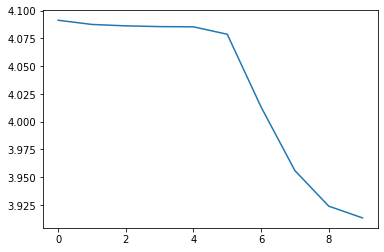

In [67]:
plt.plot(all_losses)

In [123]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=2)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

he re so to to to to to to to to to to to to to
dotn to to to to to to to to to to to to to
be toe to to to to to to to to to to to to
soun to to to to to to to to to to to

whe see to to to to to to to to to to to to to
in to to ton to to to to to to to to to to to to
in to to to to to to to to to to
grean to to see to to to to to to to to to

unee to to an to to to to to to to
in to to to to to to to to to to to
not en to to to to to to to to to so to
he re to to to to to to to to to to to

the son so to to to to to to to to to
knos to to to to to to to to to to to to to to to


In [144]:
# Save model
torch.save(rnn.state_dict(), "./lstm_onehot_model.pt")



In [119]:
# Load model
# Model class must be defined somewhere
rnn_load_model = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size)
rnn_load_model.load_state_dict(torch.load("./lstm_onehot_model.pt"))
rnn_load_model.eval()

RNN(
  (lstm): LSTM(30, 800)
  (decoder): Linear(in_features=800, out_features=30, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): Softmax(dim=2)
)

In [143]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_load_model, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=3.05)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

on to tos to to to to to enn to ton to  nos to to
dots to to to to an to to to xos toe to to
shee to to tot see to to tot
gree tot to to toje ans to to to

soun tee ton to to to to to tos to to
ve to to to to to to ton to an
unee to tot tnot an t tee toon ant to
vee to to to to to to toan to an to to anon

my seee to to to an to to to to  on to
eye sos tot so to to an to to to so
dotn toon tot an tot so to wos to an to an
for to to to to to to to sos to ton to

dee to to to an to an tos noan to to to
knou to to an to tome nat see to to to


## Embedding LSTM

In [20]:
class RNN_Embedding(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, device, batch_size, n_layers=1): # n_classes is output_size 
        super(RNN_Embedding, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'

        self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        embeding = self.embedding(input_vals)
        # pdb.set_trace()
        output, hc = self.lstm(embeding, hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(device), torch.zeros(num_layers, batch_size, hidden_size).to(device)

In [21]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 800
n_iters = 5000
print_every = 100
plot_every = 500
learning_rate = 0.0005
############################## 

rnn_embedding = RNN_Embedding(input_size=n_letters, hidden_size=hidden_size, n_classes=n_letters, n_layers=1, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn_embedding.parameters(), lr=learning_rate)

import pdb

all_losses_embed = []
total_loss_embed = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn_embedding, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss_embed += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_embed.append(total_loss_embed / plot_every)
        total_loss_embed = 0

1m 44s (100 2%) 4.1042
3m 31s (200 4%) 3.9073
5m 12s (300 6%) 3.8375
6m 52s (400 8%) 3.8363
8m 35s (500 10%) 3.8159
10m 17s (600 12%) 3.8352
12m 0s (700 14%) 3.8091
13m 45s (800 16%) 3.7896
15m 28s (900 18%) 3.8198
17m 10s (1000 20%) 3.8111
18m 53s (1100 22%) 3.7867
20m 34s (1200 24%) 3.7960
22m 17s (1300 26%) 3.7756
23m 57s (1400 28%) 3.7571
25m 39s (1500 30%) 3.7476
27m 21s (1600 32%) 3.7644
29m 4s (1700 34%) 3.7792
30m 46s (1800 36%) 3.7822
32m 28s (1900 38%) 3.7931
34m 9s (2000 40%) 3.7907
35m 53s (2100 42%) 3.7629
37m 35s (2200 44%) 3.7634
39m 17s (2300 46%) 3.7605
40m 57s (2400 48%) 3.7352
42m 36s (2500 50%) 3.7343
44m 16s (2600 52%) 3.7652
45m 55s (2700 54%) 3.7482
47m 35s (2800 56%) 3.7606
49m 17s (2900 57%) 3.7574
50m 57s (3000 60%) 3.7726
52m 37s (3100 62%) 3.7429
54m 17s (3200 64%) 3.7482
55m 56s (3300 66%) 3.7553
57m 35s (3400 68%) 3.7399
59m 14s (3500 70%) 3.7568
60m 53s (3600 72%) 3.7387
62m 32s (3700 74%) 3.7465
64m 12s (3800 76%) 3.7461
65m 55s (3900 78%) 3.7523
67m 37s

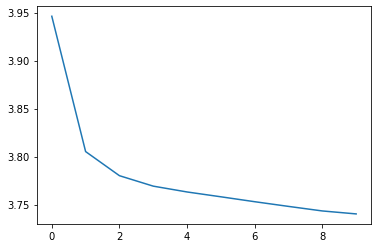

In [22]:
plt.plot(all_losses_embed)

In [94]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_embedding, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=3.05)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

my see the star that the lore the star the star
know the star the star the st'stees the
do the star the startert the star the
not the star the stare the star

or the star the shour star the s
loot the star the stane the s the shount the star
the strens the star the star
for the star the star the star the star the stant

rest the searth the shoue the
rest the short the show the star
not the star the star the star the star
the star the star the s an the

not the star the star the star
present the stane the sount the


In [145]:
torch.save(rnn_embedding.state_dict(), "./models/lstm_embedding_model.pt")


In [ ]:
# Load model
# Model class must be defined somewhere
rnn_load_model = RNN_Embedding(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size)
rnn_load_model.load_state_dict(torch.load("./models/lstm_embedding_model.pt"))
rnn_load_model.eval()